# hw2

* librosa.feature.fourier_tempogram
* librosa.feature.tempogram
* librosa.beat.tempo
* librosa.beat.beat_track
* librosa.tempo_frequencies
* librosa.fourier_tempo_frequencies

## pip install

In [9]:
!pip3 install librosa
!pip3 install mir_eval
!pip3 install pretty_midi

## import library

In [10]:
import glob
import librosa
import numpy as np
import pandas as pd
import scipy
from scipy import stats
from librosa import display
import matplotlib.pyplot as plt

## load dataset

* load in ISMIR2004 dataset

In [11]:
ISMIR2004_name = glob.glob("./ISMIR2004/*")
ISMIR2004_wav_path = [glob.glob(i+"/wav/*.wav") for i in ISMIR2004_name]
ISMIR2004_bpm_path = [glob.glob(i+"/annotation/*.bpm") for i in ISMIR2004_name]

In [12]:
def get_file_name(filepath):
  s = filepath.split('/')[-1].split('.')[0]
  return s

In [13]:
files_name = []
for gernes in ISMIR2004_wav_path:
  files_name.append([get_file_name(i) for i in gernes])

In [14]:
gernes_name = [i.split('/')[-1] for i in ISMIR2004_name]

In [15]:
all_bpm_num = []
for n, gernes in zip(files_name, ISMIR2004_name):
  bpm_num = []
  for i in n:
    n = pd.read_csv(glob.glob(gernes+"/annotation/"+i+"*.bpm")[0], sep=" ", header=None)
    bpm_num.append(n[0][0])
  all_bpm_num.append(bpm_num)

## Task 1: tempo estimation

Design an algorithm that estimate the tempo for the ISMIR2004 and the Ballroom dataset. Assume that the tempo of every clip is constant.

### design the algorithm

*function code*

In [16]:
def tempo(
    *,
    y=None,
    sr=22050,
    onset_envelope=None,
    hop_length=512,
    start_bpm=120,
    std_bpm=1.0,
    time_size=8.0,
    max_tempo=320.0,
    aggregate=np.mean,
    fourier = False,
    prior=None
):
    if start_bpm <= 0:
        raise librosa.util.exceptions.ParameterError("start_bpm must be strictly positive")

    win_length = librosa.core.time_to_frames(time_size, sr=sr, hop_length=hop_length).item()

    if fourier is True:
      tg = librosa.feature.fourier_tempogram(
        y=y,
        sr=sr,
        onset_envelope=onset_envelope,
        hop_length=hop_length,
        win_length=win_length,
    )
    else:
      tg = librosa.feature.tempogram(
          y=y,
          sr=sr,
          onset_envelope=onset_envelope,
          hop_length=hop_length,
          win_length=win_length,
      )


    # Eventually, we want this to work for time-varying tempo
    if aggregate is not None:
        tg = aggregate(tg, axis=-1, keepdims=True)
    # Get the BPM values for each bin, skipping the 0-lag bin
    bpms = librosa.core.tempo_frequencies(tg.shape[-2], hop_length=hop_length, sr=sr)
    
    # Weight the autocorrelation by a log-normal distribution
    if prior is None:
        logprior = -0.5 * ((np.log2(bpms) - np.log2(start_bpm)) / std_bpm) ** 2
    else:
        logprior = prior.logpdf(bpms)

    # Kill everything above the max tempo
    if max_tempo is not None:
        max_idx = np.argmax(bpms < max_tempo)
        logprior[:max_idx] = -np.inf
    # explicit axis expansion
    logprior = expand_to(logprior, ndim=tg.ndim, axes=-2)

    # Get the maximum, weighted by the prior
    # Using log1p here for numerical stability
    best_periods = np.argpartition(np.log1p(1e6 * tg) + logprior, axis=-2, kth=-2)[-2:]

    return (np.take(bpms, best_periods),np.take(np.log1p(1e6 * tg) + logprior, best_periods))

In [17]:
def expand_to(x, *, ndim, axes):
    try:
        axes = tuple(axes)
    except TypeError:
        axes = tuple([axes])

    if len(axes) != x.ndim:
        raise librosa.util.exceptions.ParameterError(
            "Shape mismatch between axes={} and input x.shape={}".format(axes, x.shape)
        )

    if ndim < x.ndim:
        raise librosa.util.exceptions.ParameterError(
            "Cannot expand x.shape={} to fewer dimensions ndim={}".format(x.shape, ndim)
        )

    shape = [1] * ndim
    for i, axi in enumerate(axes):
        shape[axi] = x.shape[i]

    return x.reshape(shape)

In [18]:
def tempo_estimate(T, G):
  if np.abs((G-T)/G) < 0.08:
    return 1
  else:
    return 0

def get_ans(tempo, G, weight):
  if tempo[0][0]<tempo[0][1]:
    t1 = tempo[0][0]
    t2 = tempo[0][1]
    s1 = tempo[1][0]/sum(tempo[1])
  else:
    t1 = tempo[0][1]
    t2 = tempo[0][0]
    s1 = tempo[1][1]/sum(tempo[1])
  p_score = s1[0]*tempo_estimate(t1*weight, G)+(1-s1[0])*tempo_estimate(t2*weight, G)
  if tempo_estimate(t1*weight, G)==0 & tempo_estimate(t2*weight, G)==0:
    ALOTC_scores = 0
  else:
    ALOTC_scores = 1
  return (t1[0], t2[0], p_score, ALOTC_scores)

### Q1 (20%)

Note that your algorithm should output two predominant tempi for each clip: 𝑇 (the slower one) and 𝑇 (the faster one). Please compare and discuss the **results computed from the Fourier tempogram and the autocorrelation tempogram.**

**Compute the average P-scores and the ALOTC scores** of the ISMIR2004 dataset and the eight genres (Cha Cha, Jive, Quickstep, Rumba, Samba, Tango, Viennese Waltz and Slow Waltz) in the Ballroom dataset using your algorithms.

#### code

* Fourier tempogram

In [19]:
def Q1_auto(filepath, G):
  y, sr = librosa.load(filepath)
  onset_env = librosa.onset.onset_strength(y=y, sr=sr)
  # autocorrelation tempogram
  T = tempo(onset_envelope=onset_env, sr=sr)
  auto_ans = get_ans(T, G, 1)
  print(auto_ans)
  return (auto_ans)

In [20]:
def avg_auto_ans(gernepaths, bpms):
  length = len(gernepaths)
  f_auto_list = [Q1_auto(gernepaths[i], bpms[i]) for i in range(0, length)]
  f_auto_df = pd.DataFrame(f_auto_list)
  ans = []
  for i in range(0, 4):
    ans.append(sum(f_auto_df[i])/length)
  print(ans)
  return ans

* autocorrelation tempogram

In [21]:
def Q1_Fourier(filepath, G):
  y, sr = librosa.load(filepath)
  onset_env = librosa.onset.onset_strength(y=y, sr=sr)
  # Fourier tempogram
  T = tempo(onset_envelope=onset_env, sr=sr, fourier = True)
  Fourier_ans = get_ans(T, G, 1)
  print(Fourier_ans)
  return (Fourier_ans)

In [22]:
def avg_Fourier_ans(gernepaths, bpms):
  length = len(gernepaths)
  f_Fourier_list = [Q1_Fourier(gernepaths[i], bpms[i]) for i in range(0, length)]
  f_Fourier_df = pd.DataFrame(f_Fourier_list)
  ans = []
  for i in range(0, 4):
    ans.append(sum(f_Fourier_df[i])/length)
  print(ans)
  return ans

In [23]:
Fourier_ans_list = []
auto_ans_list = []
for g, b in zip(ISMIR2004_wav_path, all_bpm_num):
  Fourier_ans_list.append(avg_Fourier_ans(g, b))
  auto_ans_list.append(avg_auto_ans(g, b))

(151.99908088235293, 161.4990234375, 0j, 0)
(123.046875, 129.19921875, 0j, 0)
(161.4990234375, 172.265625, 0j, 0)
(117.45383522727273, 198.76802884615384, 0j, 0)
(73.828125, 78.30255681818181, (0.5053965760905814-0.07266822307742346j), 0)
(129.19921875, 258.3984375, 0j, 0)
(151.99908088235293, 161.4990234375, 0j, 0)
(135.99917763157896, 234.90767045454547, 0j, 0)
[130.6280521013822, 174.35494803048513, (0.06317457201132268-0.009083527884677933j), 0.0]
(161.4990234375, 172.265625, 0.0, 0)
(151.99908088235293, 161.4990234375, 0.0, 0)
(112.34714673913044, 117.45383522727273, 0.0, 0)
(86.1328125, 89.10290948275862, 1.0, 1)
(123.046875, 129.19921875, 0.0, 0)
(75.99954044117646, 151.99908088235293, 0.499219309075009, 1)
(123.046875, 129.19921875, 0.0, 0)
(161.4990234375, 172.265625, 0.0, 0)
[124.44629717970749, 140.37306706623554, 0.18740241363437612, 0.25]


KeyboardInterrupt: 

#### show the results

* Fourier tempogram

In [22]:
Fourier_ans_df = pd.DataFrame(Fourier_ans_list)
Fourier_ans_df.columns = ['t1', 't2', 'p score', 'ALOTC score']
Fourier_ans_df.index = gernes_name

In [26]:
Fourier_ans_df.to_csv("Fourier_ans_df_i.csv")

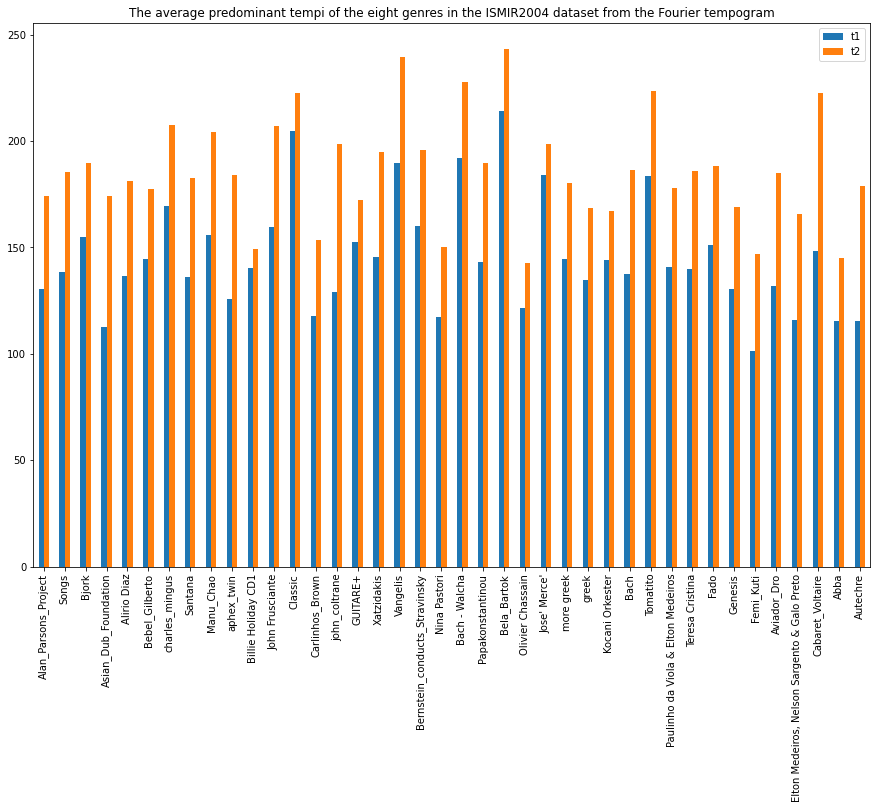

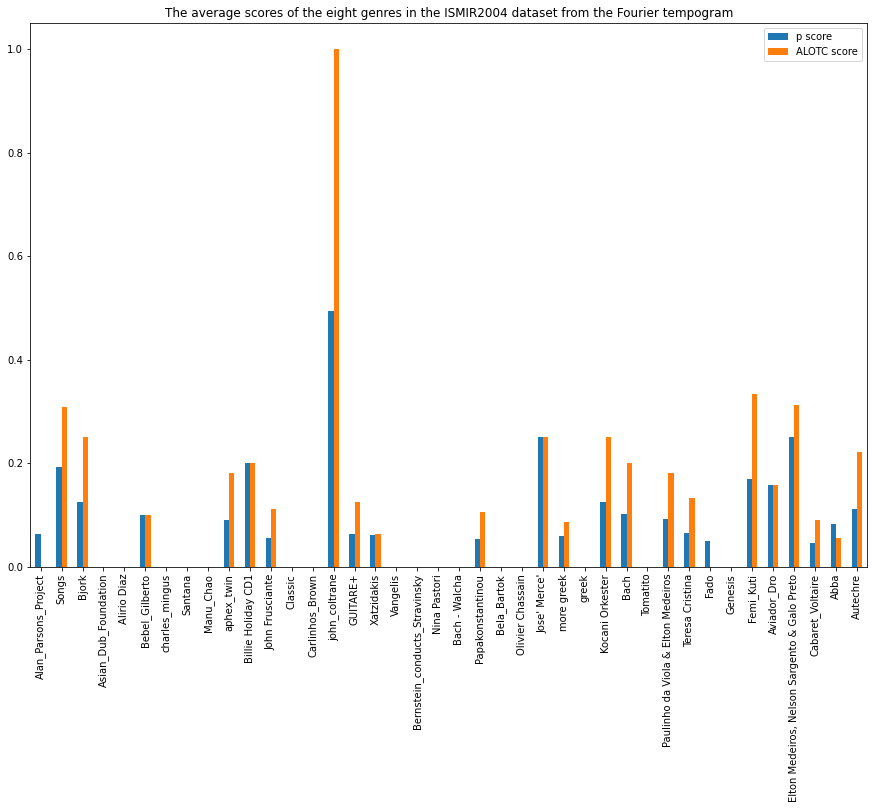

In [38]:
plot1 = Fourier_ans_df.iloc[:, 0:2].plot(figsize=(15,10), kind = "bar", title = "The average predominant tempi of the eight genres in the ISMIR2004 dataset from the Fourier tempogram")
plot2 = Fourier_ans_df.iloc[:, 2:4].plot(figsize=(15,10), kind = "bar", title = "The average scores of the eight genres in the ISMIR2004 dataset from the Fourier tempogram")

* autocorrelation tempogram

In [27]:
auto_ans_df = pd.DataFrame(auto_ans_list)
auto_ans_df.columns = ['t1', 't2', 'p score', 'ALOTC score']
auto_ans_df.index = gernes_name

In [29]:
auto_ans_df.to_csv("auto_ans_df_i.csv")

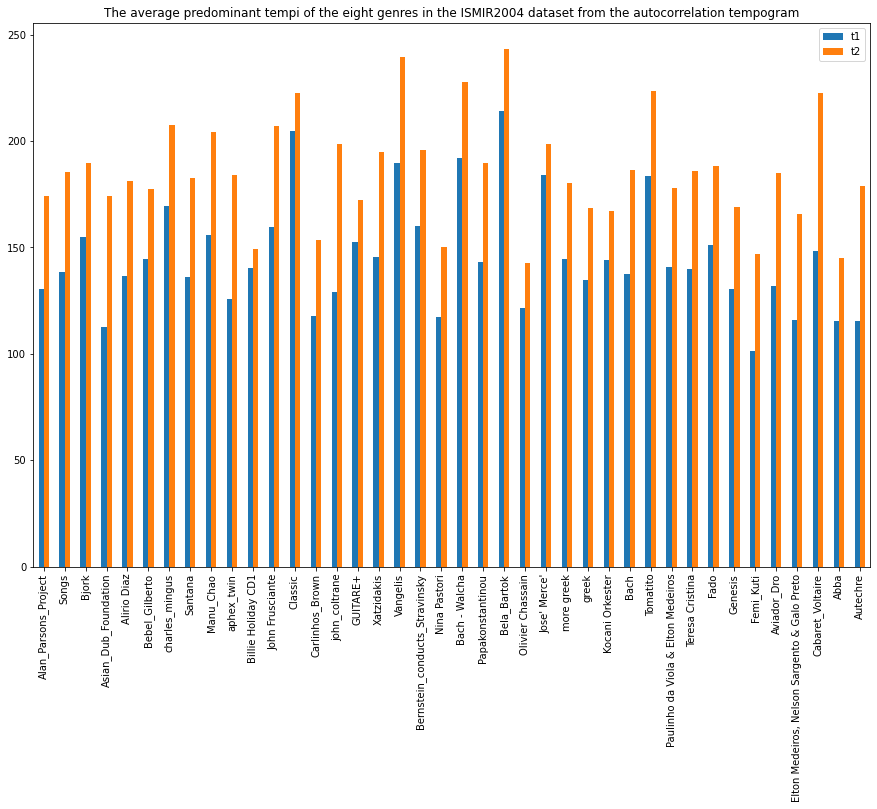

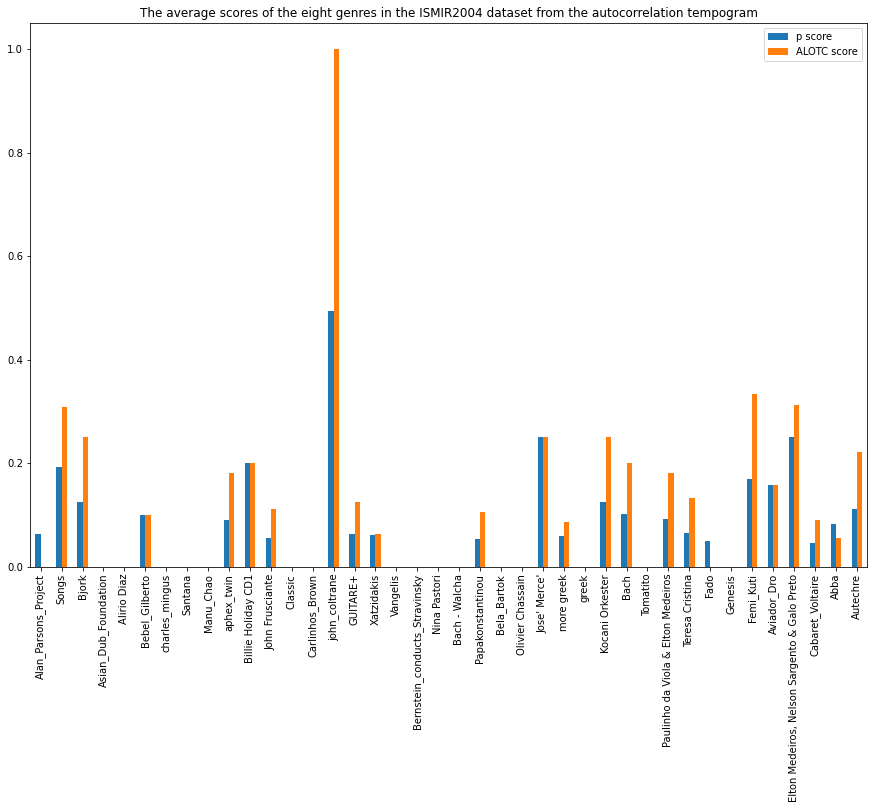

In [31]:
plot3 = Fourier_ans_df.iloc[:, 0:2].plot(figsize=(15,10), kind = "bar", title = "The average predominant tempi of the eight genres in the ISMIR2004 dataset from the autocorrelation tempogram")
plot4 = Fourier_ans_df.iloc[:, 2:4].plot(figsize=(15,10), kind = "bar", title = "The average scores of the eight genres in the ISMIR2004 dataset from the autocorrelation tempogram")

### Q2 (20%)

Instead of using your estimated [𝑇 , 𝑇 ] in evaluation, try to use [𝑇 /2, 𝑇 /2] , 
[𝑇 /3, 𝑇 /3], [2𝑇 , 2𝑇 ], and [3𝑇 , 3𝑇 ] for estimation. What are the resulting **P-score** values? Also, compare and discuss the **results using the Fourier tempogram and the autocorrelation tempogram.**


#### code

In [24]:
weight_list = [1/2, 1/3, 2, 3]

* Fourier tempogram

In [25]:
def Q2_Fourier(filepath, G, w):
  y, sr = librosa.load(filepath)
  onset_env = librosa.onset.onset_strength(y=y, sr=sr)
  # Fourier tempogram
  T = tempo(onset_envelope=onset_env, sr=sr, fourier = True)
  Fourier_ans = get_ans(T, G, w)[0:3]
  print(Fourier_ans)
  return Fourier_ans

In [26]:
def avg_Fourier_ans(gernepaths, bpms):
  length = len(gernepaths)
  f_Fourier_df_list = []
  for w in weight_list:
    f_Fourier_list = [Q2_Fourier(gernepaths[i], bpms[i], w) for i in range(0, length)]
    f_Fourier_df = pd.DataFrame(f_Fourier_list)
    f_Fourier_df_list.append(f_Fourier_df)
  ans_list = []
  for f in f_Fourier_df_list:
    ans = []
    for i in range(0, 3):
      ans.append(sum(f[i])/length)
    ans_list.append(ans)
  print(ans_list)
  return ans_list

* autocorrelation tempogram

In [27]:
def Q2_auto(filepath, G, w):
  y, sr = librosa.load(filepath)
  onset_env = librosa.onset.onset_strength(y=y, sr=sr)
  # autocorrelation tempogram
  T = tempo(onset_envelope=onset_env, sr=sr)
  auto_ans = get_ans(T, G, w)[0:3]
  return auto_ans

In [28]:
def avg_auto_ans(gernepaths, bpms):
  length = len(gernepaths)
  f_auto_df_list = []
  for w in weight_list:
    f_auto_list = [Q2_auto(gernepaths[i], bpms[i], w) for i in range(0, length)]
    f_auto_df = pd.DataFrame(f_auto_list)
    f_auto_df_list.append(f_auto_df)
  ans_list = []
  print(f_auto_df_list)
  for f in f_auto_df_list:
    ans = []
    for i in range(0, 3):      
      ans.append(sum(f[i])/length)
    ans_list.append(ans)
  return ans_list

In [ ]:
  for f in f_auto_df_list:
    ans = []
    for i in range(0, 3):      
      ans.append(sum(f[i])/length)
    ans_list.append(ans)

In [134]:
Fourier_ans_list

[]

In [ ]:
Fourier_ans_list = []
auto_ans_list = []
for g, b in zip(ISMIR2004_wav_path, all_bpm_num):
  Fourier_b_list.append(avg_Q2_ans(g, b, True))
  auto_b_list.append(avg_Q2_ans(g, b, None))

#### show the results

* Fourier tempogram

In [ ]:
Fourier_ans_df.columns = ['t1', 't2', 'p score','ALOTC score']

In [166]:
Q2_b_f_df = pd.read_csv("./Q3/Q3_Fourier_ans_df_b.csv")

In [167]:
Q2_b_f_df

,Unnamed: 0,0,1,2,3,4
0,Jive,0.166667,0.250000,0.150000,0.133333,0.083333
1,Quickstep,0.146341,0.036585,0.158537,0.085366,0.121951
2,Rumba,0.163265,0.091837,0.357143,0.061224,0.091837
3,Samba,0.279070,0.139535,0.162791,0.127907,0.093023
4,Tango,0.174419,0.093023,0.139535,0.267442,0.151163
5,Viennese waltz,0.153846,0.015385,0.123077,0.030769,0.076923
6,Waltz,0.009091,0.036364,0.000000,0.290909,0.036364
7,ChaCha,0.144144,0.081081,0.027027,0.252252,0.153153


In [153]:
Q2_i_f_df.iloc[0,1]

'[130.6280521013822, 174.35494803048513, (0.06273933844123997-0.009015988078227594j)]'

In [113]:
Fourier_ans_df_all = pd.DataFrame(Fourier_ans_list[0:40][0])
Fourier_ans_df_all

,0,1,2
0,130.628052,174.354948,0.062739-0.009016j
1,130.628052,174.354948,0.000000+0.000000j
2,130.628052,174.354948,0.000000+0.000000j
3,130.628052,174.354948,0.000000+0.000000j


In [80]:
for i in range(0, 4):
  Fourier_ans_df = pd.DataFrame(Fourier_ans_df_all[i])
  Fourier_ans_df.columns = ['t1', 't2', 'p score']
  Fourier_ans_df.index = gernes_name
  Fourier_ans_df
  # Fourier_ans_df.to_csv("Q2_Fourier_ans_df_i"+idx+".csv")

ValueError: Length mismatch: Expected axis has 1 elements, new values have 3 elements

In [102]:
Fourier_ans_df[0]

[138.21086328970307,
 185.64873609581173,
 (0.07611587627811191+0.004079383922457819j)]

In [42]:
plot1 = Fourier_ans_df.iloc[0, 0:2].plot(figsize=(15,10), kind = "bar", title = "The average predominant tempi of the eight genres in the ISMIR2004 dataset from the Fourier tempogram")
plot2 = Fourier_ans_df.iloc[0, 2:3].plot(figsize=(15,10), kind = "bar", title = "The average P scores of the eight genres in the ISMIR2004 dataset from the Fourier tempogram")

TypeError: no numeric data to plot

* autocorrelation tempogram

In [120]:
auto_ans_df = pd.DataFrame(auto_ans_list) 
auto_ans_df.index = gernes_name
auto_ans_df.to_csv("Q2_auto_ans_df_i.csv")
Fourier_ans_df = pd.DataFrame(Fourier_ans_list) 
Fourier_ans_df.index = gernes_name
Fourier_ans_df.to_csv("Q2_Fourier_ans_df_i.csv")

In [ ]:
plot3 = auto_ans_df.iloc[:, 0:2].plot(kind = "bar", title = "The average predominant tempi of the eight genres in the Ballroom dataset from the autocorrelation tempogram")
plot4 = auto_ans_df.iloc[:, 2:4].plot(kind = "bar", title = "The average scores of the eight genres in the Ballroom dataset from the autocorrelation tempogram")

In [ ]:
for i in auto_ans_list:
  auto_ans_df = pd.DataFrame(i)
  auto_ans_df.columns = ['t1', 't2', 'p score']
  auto_ans_df.index = gernes_name
  plot3 = auto_ans_df.iloc[:, 0:2].plot(kind = "bar", title = "The average predominant tempi of the eight genres in the Ballroom dataset from the autocorrelation tempogram")
  plot4 = auto_ans_df.iloc[:, 2:4].plot(kind = "bar", title = "The average scores of the eight genres in the Ballroom dataset from the autocorrelation tempogram")
  fig = plot3.get_figure()
  fig.savefig("Q2_auto_tempo"+i+".png")
  fig = plot4.get_figure()
  fig.savefig("Q2_auto_scores"+i+".png")

### Q3 (20%)

The window length is also an important factor in tempo estimation. Try to use 4s, 6s, 8s, 10s, 12s for both Fourier tempogram and the autocorrelation tempogram and compare the **ALOTC** of the eight genres in the Ballroom dataset and ISMIR2004 dataset.

#### code

In [121]:
time_list = [4, 6, 8, 10, 12]

In [126]:
def Q3(filepath, G, t, temp):
  y, sr = librosa.load(filepath)
  onset_env = librosa.onset.onset_strength(y=y, sr=sr)
  T = tempo(onset_envelope=onset_env, sr=sr, time_size=t, fourier = temp)
  ans = get_ans(T, G, 1)[3]
  return ans

In [127]:
def avg_Q3_ans(gernepaths, bpms, temp):
  length = len(gernepaths)
  f_df_list = []
  for t in time_list:
    f_list = [Q4(gernepaths[i], bpms[i], t, temp) for i in range(0, length)]
    f_df = pd.DataFrame(f_list)
    f_df_list.append(f_df)
  ans_list = []
  for f in f_df_list:
    ans_list.append(sum(f[0])/length)
  print(ans_list)
  return ans_list

#### run datasets

In [168]:
Fourier_b_list = []
auto_b_list = []
for g, b in zip(ISMIR2004_wav_path, all_bpm_num):
  Fourier_b_list.append(avg_Q3_ans(g, b, True))
  auto_b_list.append(avg_Q3_ans(g, b, None))

[0.0, 0.0, 0.0, 0.0, 0.0]
[0.125, 0.25, 0.25, 0.25, 0.25]
[0.07692307692307693, 0.23076923076923078, 0.3076923076923077, 0.07692307692307693, 0.07692307692307693]
[0.5384615384615384, 0.46153846153846156, 0.46153846153846156, 0.46153846153846156, 0.46153846153846156]
[0.25, 0.08333333333333333, 0.25, 0.0, 0.0]
[0.25, 0.25, 0.25, 0.25, 0.25]
[0.0, 0.23076923076923078, 0.0, 0.07692307692307693, 0.07692307692307693]
[0.23076923076923078, 0.23076923076923078, 0.3076923076923077, 0.3076923076923077, 0.3076923076923077]
[0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.25, 0.25, 0.25]
[0.1, 0.0, 0.1, 0.1, 0.1]
[0.2, 0.2, 0.2, 0.2, 0.2]
[0.0, 0.16666666666666666, 0.0, 0.16666666666666666, 0.0]
[0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666, 0.6666666666666666]
[0.0, 0.6666666666666666, 0.0, 0.6666666666666666, 0.3333333333333333]
[1.0, 1.0, 1.0, 1.0, 1.0]
[0.3333333333333333, 0.0, 0.0, 0.0, 0.0]
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.5, 0.5]
[0.18

In [170]:
auto_ans_list

[]

In [174]:
len(auto_b_list)

80

In [175]:
auto_ans_df = pd.DataFrame(auto_b_list[0:40]) 
auto_ans_df.index = gernes_name
auto_ans_df.to_csv("Q3_auto_ans_df_i.csv")
Fourier_ans_df = pd.DataFrame(Fourier_b_list[0:40]) 
Fourier_ans_df.index = gernes_name
Fourier_ans_df.to_csv("Q3_Fourier_ans_df_i.csv")

#### show the results

* ballroom

In [ ]:
for i in Fourier_b_list:
  auto_ans_df = pd.DataFrame(i)
  auto_ans_df.columns = ['p score']
  auto_ans_df.index = gernes_name
  plot = auto_ans_df.plot(kind = "bar", title = "The average ALOTC scores of the eight genres in the Ballroom dataset from the autocorrelation tempogram")
  fig = plot.get_figure()
  fig.savefig("Q3_Fourier_scores_b.png")

In [ ]:
for i in auto_b_list:
  auto_ans_df = pd.DataFrame(i)
  auto_ans_df.columns = ['p score']
  auto_ans_df.index = gernes_name
  plot = auto_ans_df.plot(kind = "bar", title = "The average ALOTC scores of the eight genres in the Ballroom dataset from the autocorrelation tempogram")
  fig = plot.get_figure()
  fig.savefig("Q3_auto_scores_b.png")

* ISMIR2004

In [ ]:
for i in Fourier_I_list:
  auto_ans_df = pd.DataFrame(i)
  auto_ans_df.columns = ['p score']
  auto_ans_df.index = gernes_name
  plot = auto_ans_df.plot(kind = "bar", title = "The average ALOTC scores of the eight genres in the Ballroom dataset from the autocorrelation tempogram")
  fig = plot.get_figure()
  fig.savefig("Q3_Fourier_scores_i.png")

In [ ]:
for i in auto_I_list:
  auto_ans_df = pd.DataFrame(i)
  auto_ans_df.columns = ['p score']
  auto_ans_df.index = gernes_name
  plot = auto_ans_df.plot(kind = "bar", title = "The average ALOTC scores of the eight genres in the Ballroom dataset from the autocorrelation tempogram")
  fig = plot.get_figure()
  fig.savefig("Q3_auto_scores_i.png")